# Task 1

In [27]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# file_path = '/content/drive/.shortcut-targets-by-id/1vkknCL6OjwZzWbtKB-zBXYSXEFQyKkjV/stats m148/dat_train1.csv'
file_path = 'dat_train1.csv'

df = pd.read_csv(file_path)
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])

# define a duplicate as same user, same action, same time
duplicate_mask = df.duplicated(subset=['customer_id', 'event_name', 'event_timestamp'], keep='first')
num_duplicates = duplicate_mask.sum()
total_rows_before = len(df)
proportion_duplicates = num_duplicates / total_rows_before

# remove duplicates
df_clean = df[~duplicate_mask].copy()
total_rows_after = len(df_clean)

# fix action counter (journey_steps_until_end)
# sort by customer and time, then group by customer to re-assign the step numbers
df_clean = df_clean.sort_values(by=['customer_id', 'event_timestamp'])
df_clean['journey_steps_until_end'] = df_clean.groupby('customer_id').cumcount() + 1

# 1. Filter for successful orders only
# df_clean is the dataframe after removing duplicates in Task 2
df_orders = df_clean[df_clean['event_name'] == 'order_shipped'].copy()

# Ensure the timestamp is in datetime format
df_orders['event_timestamp'] = pd.to_datetime(df_orders['event_timestamp'])

# Cut off data so it starts in Feb 2021 (data providers mentioned the first little stretch is inaccurate)
df_orders = df_orders[df_orders['event_timestamp'] >= '2021-02-01'].copy()

11:50:33 - cmdstanpy - INFO - Chain [1] start processing
11:50:33 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


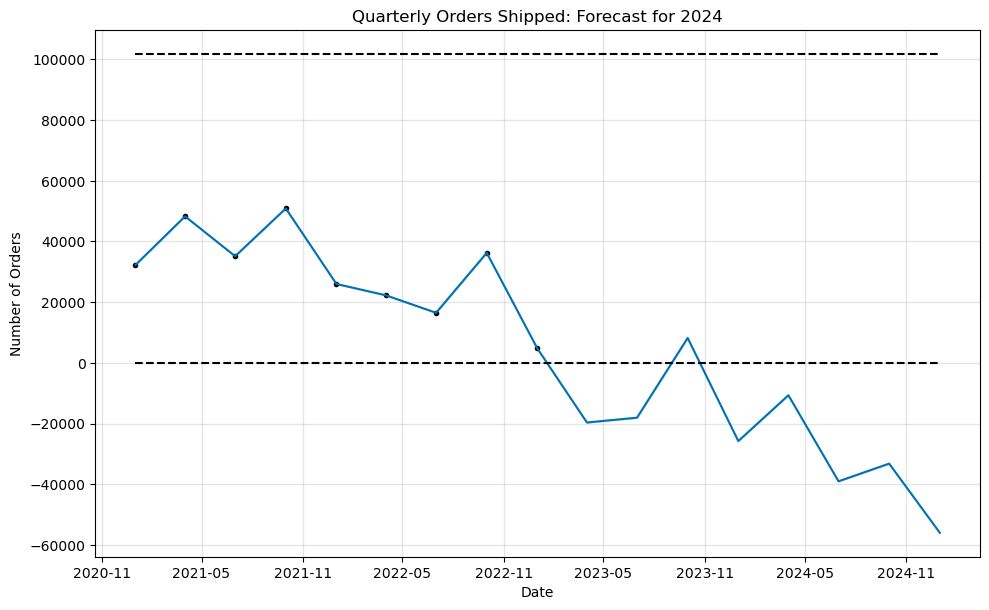

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

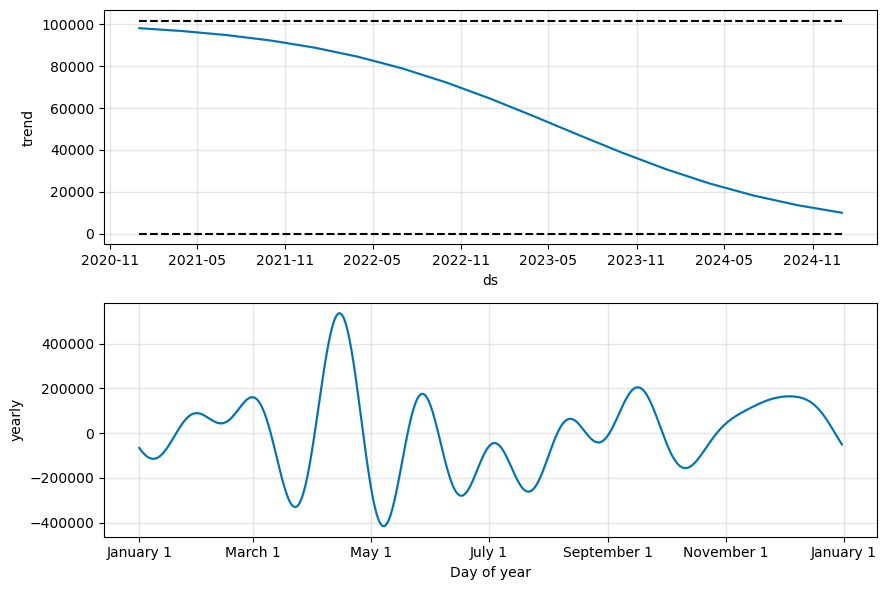

In [28]:
# 2. Resample to Quarter Start (QS) to get quarterly aggregate of orders
quarterly_series = df_orders.resample('QS', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
quarterly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
quarterly_series['ds'] = quarterly_series['ds'].dt.tz_localize(None)

# Add cap and floor columns for logistic growth
# We set the floor to 0 to prevent negative predictions
quarterly_series['floor'] = 0
# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = quarterly_series['y'].max()
quarterly_series['cap'] = max_orders * 2

# 3. Fit the model using logistic growth to enforce the floor and cap
m = Prophet(growth='logistic')
m.fit(quarterly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 8 quarters into the future
future = m.make_future_dataframe(periods=8, freq='QS')

# The future dataframe also needs the cap and floor defined
future['floor'] = 0
future['cap'] = max_orders * 2

forecast = m.predict(future)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Quarterly Orders Shipped: Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

11:50:34 - cmdstanpy - INFO - Chain [1] start processing
11:50:34 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


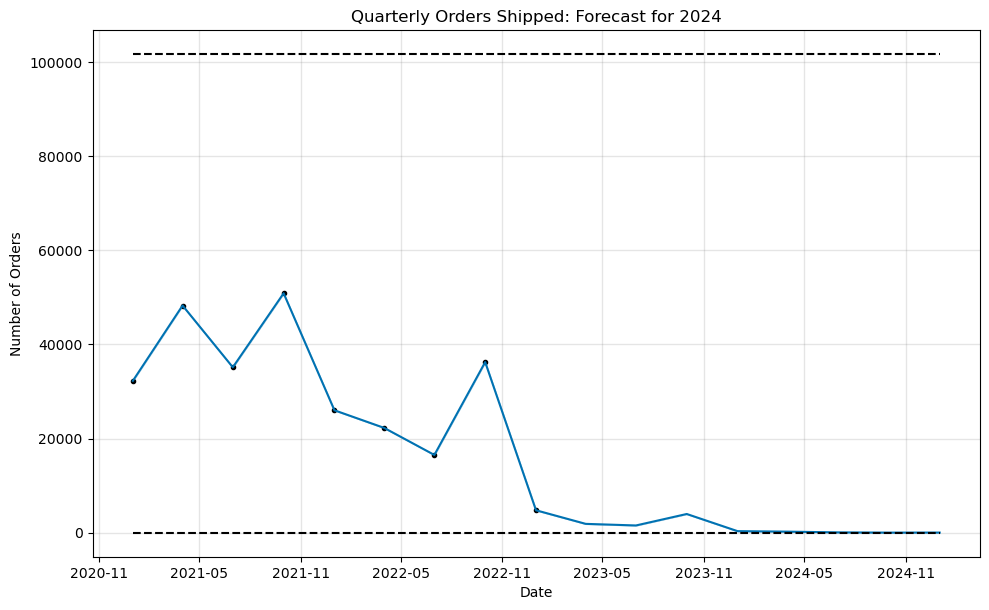

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

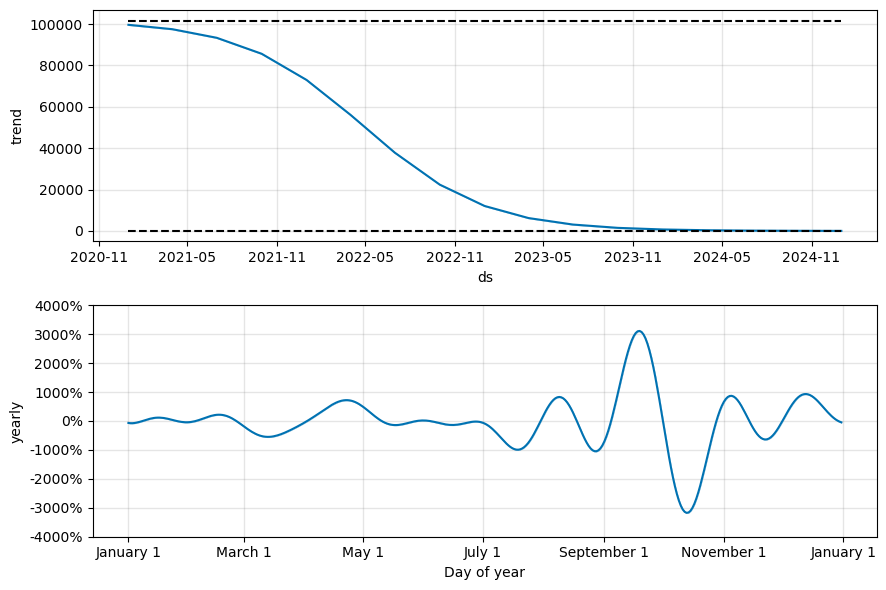

In [29]:
# 2. Resample to Quarter Start (QS) to get quarterly aggregate of orders
quarterly_series = df_orders.resample('QS', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
quarterly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
quarterly_series['ds'] = quarterly_series['ds'].dt.tz_localize(None)

# Add cap and floor columns for logistic growth
# We set the floor to 0 to prevent negative predictions
quarterly_series['floor'] = 0
# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = quarterly_series['y'].max()
quarterly_series['cap'] = max_orders * 2

# 3. Fit the model using logistic growth AND multiplicative seasonality
m = Prophet(growth='logistic', seasonality_mode='multiplicative')
m.fit(quarterly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 8 quarters into the future
future = m.make_future_dataframe(periods=8, freq='QS')

# The future dataframe also needs the cap and floor defined
future['floor'] = 0
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Force any stray negative predictions in the main forecast and lower confidence interval to be 0
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Quarterly Orders Shipped: Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

11:50:35 - cmdstanpy - INFO - Chain [1] start processing
11:50:35 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


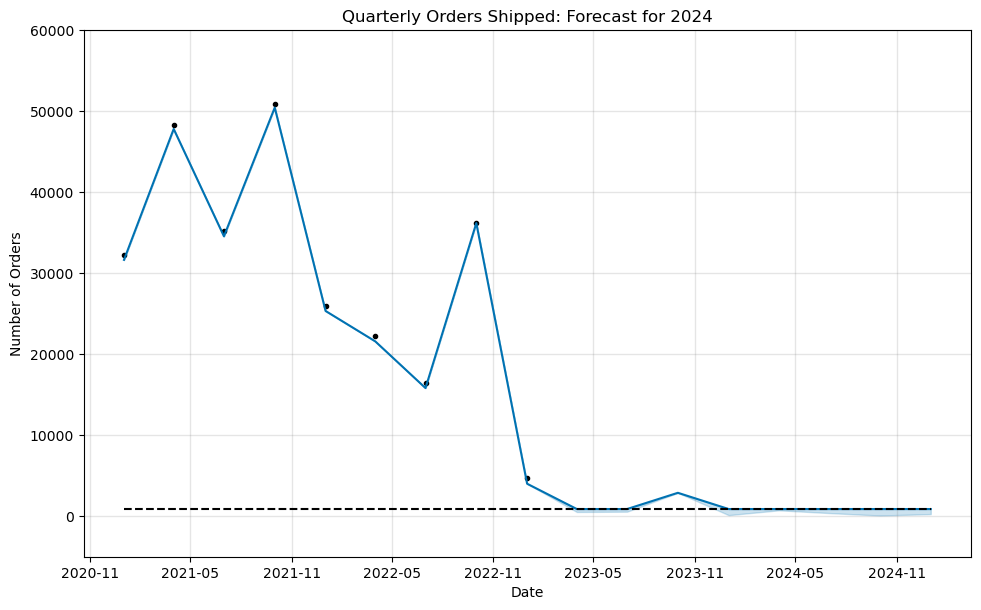

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

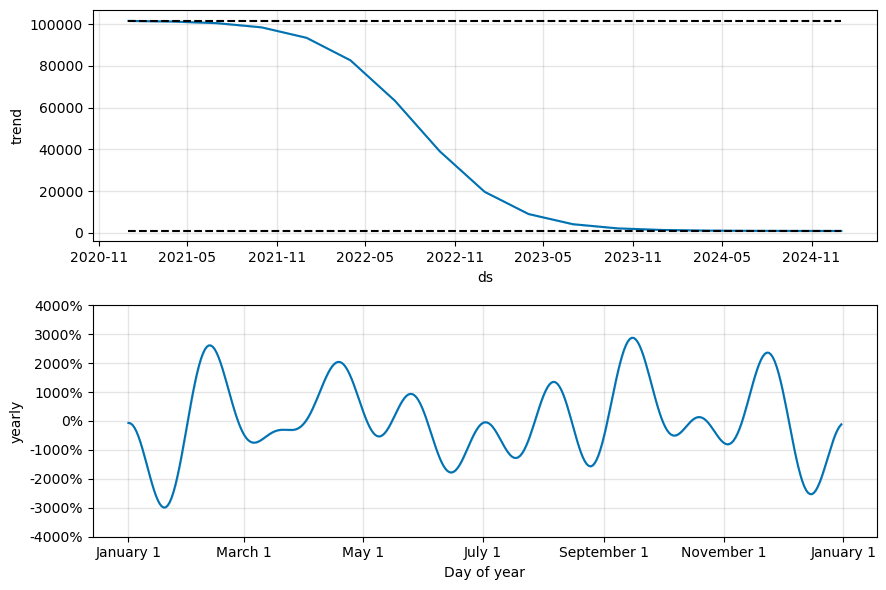

In [30]:
# 2. Resample to Quarter Start (QS) to get quarterly aggregate of orders
quarterly_series = df_orders.resample('QS', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
quarterly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
quarterly_series['ds'] = quarterly_series['ds'].dt.tz_localize(None)

# Add cap and floor columns for logistic growth
# We set the floor to a small baseline to represent the remaining userbase, preventing negative predictions
baseline_orders = quarterly_series['y'].mean() * 0.03
quarterly_series['floor'] = baseline_orders

# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = quarterly_series['y'].max()
quarterly_series['cap'] = max_orders * 2

# 3. Fit the model using logistic growth to enforce the floor and cap, and multiplicative seasonality
m = Prophet(growth='logistic', seasonality_mode='multiplicative')
m.fit(quarterly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 8 quarters into the future
future = m.make_future_dataframe(periods=8, freq='QS')

# The future dataframe also needs the cap and floor defined
future['floor'] = baseline_orders
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Force any stray predictions in the confidence intervals to respect our baseline floor
forecast['yhat'] = forecast['yhat'].clip(lower=baseline_orders)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=baseline_orders)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Quarterly Orders Shipped: Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.ylim(top = 60000)
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

11:50:35 - cmdstanpy - INFO - Chain [1] start processing
11:50:35 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


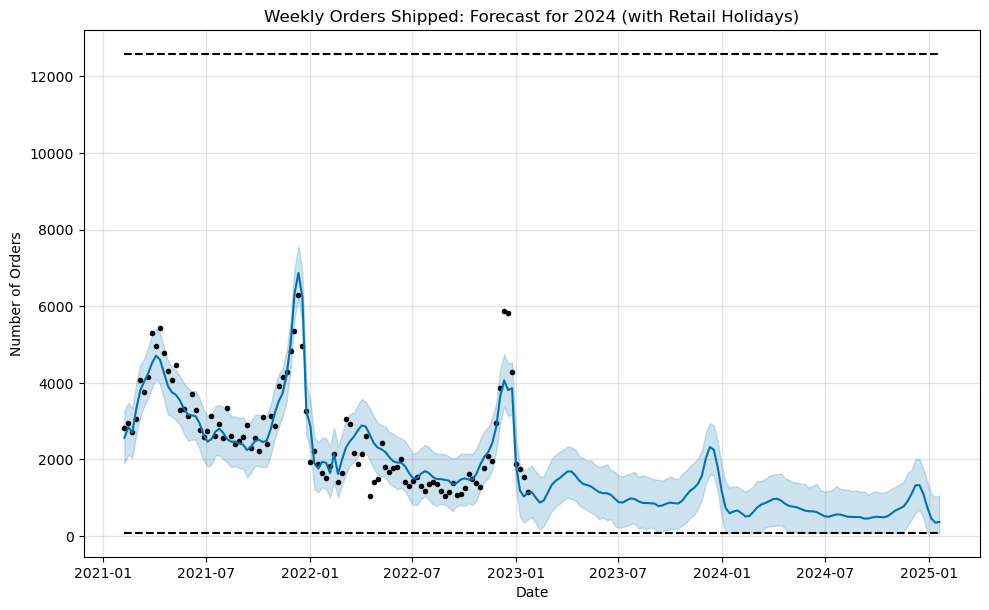

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

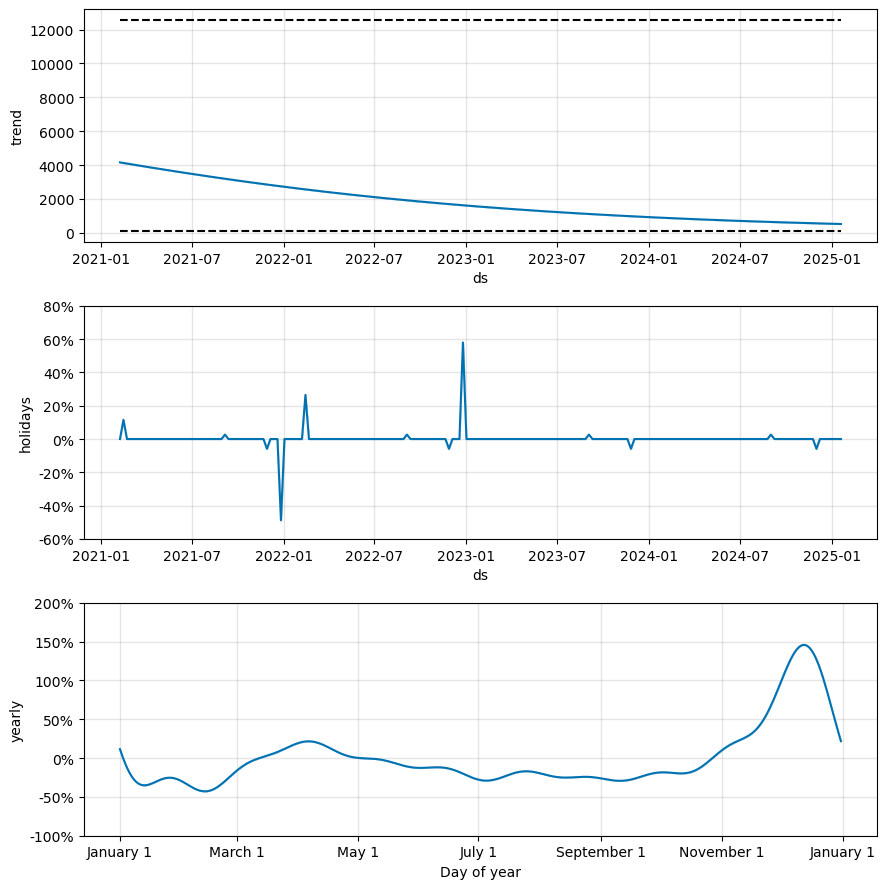

In [31]:
# 2. Resample to Weekly (W) to get weekly aggregate of orders
# We switch to weekly so holidays are not absorbed by quarterly seasonality
weekly_series = df_orders.resample('W', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
weekly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
weekly_series['ds'] = weekly_series['ds'].dt.tz_localize(None)

# FIX: Drop the final row because it is likely an incomplete week (e.g., ends on a Tuesday)
# This prevents the model from learning an artificial massive drop at the end of the training data
weekly_series = weekly_series.iloc[:-1].copy()

# Add cap and floor columns for logistic growth
# We set the floor to a small baseline to represent the remaining userbase, preventing negative predictions
baseline_orders = weekly_series['y'].mean() * 0.03
weekly_series['floor'] = baseline_orders

# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = weekly_series['y'].max()
weekly_series['cap'] = max_orders * 2

# Define the retail holidays for Fingerhut's specific inventory (2021-2024)
holidays_data = {
    'holiday': [
        'Black Friday', 'Black Friday', 'Black Friday', 'Black Friday',
        'Cyber Monday', 'Cyber Monday', 'Cyber Monday', 'Cyber Monday',
        'Christmas', 'Christmas', 'Christmas', 'Christmas',
        'Valentines', 'Valentines', 'Valentines', 'Valentines',
        'Labor Day', 'Labor Day', 'Labor Day', 'Labor Day'
    ],
    'ds': pd.to_datetime([
        '2021-11-26', '2022-11-25', '2023-11-24', '2024-11-29', # Black Friday
        '2021-11-29', '2022-11-28', '2023-11-27', '2024-12-02', # Cyber Monday
        '2021-12-25', '2022-12-25', '2023-12-25', '2024-12-25', # Christmas
        '2021-02-14', '2022-02-14', '2023-02-14', '2024-02-14', # Valentines (Jewelry)
        '2021-09-06', '2022-09-05', '2023-09-04', '2024-09-02'  # Labor Day (Appliances)
    ]),
    'lower_window': -3, # Extends the holiday effect 3 days before
    'upper_window': 3   # Extends the holiday effect 3 days after to match the weekly grouping
}
retail_holidays = pd.DataFrame(holidays_data)

# 3. Fit the model using logistic growth, multiplicative seasonality, and retail holidays
# We forcefully set yearly_seasonality=True because our dataset is just barely under 730 days
m = Prophet(
    growth='logistic', 
    seasonality_mode='multiplicative', 
    holidays=retail_holidays,
    yearly_seasonality=True
)
m.fit(weekly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 104 weeks (2 years) into the future
future = m.make_future_dataframe(periods=104, freq='W')

# The future dataframe also needs the cap and floor defined
future['floor'] = baseline_orders
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Force any stray predictions in the confidence intervals to respect our baseline floor
forecast['yhat'] = forecast['yhat'].clip(lower=baseline_orders)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=baseline_orders)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Weekly Orders Shipped: Forecast for 2024 (with Retail Holidays)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

11:50:36 - cmdstanpy - INFO - Chain [1] start processing
11:50:36 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


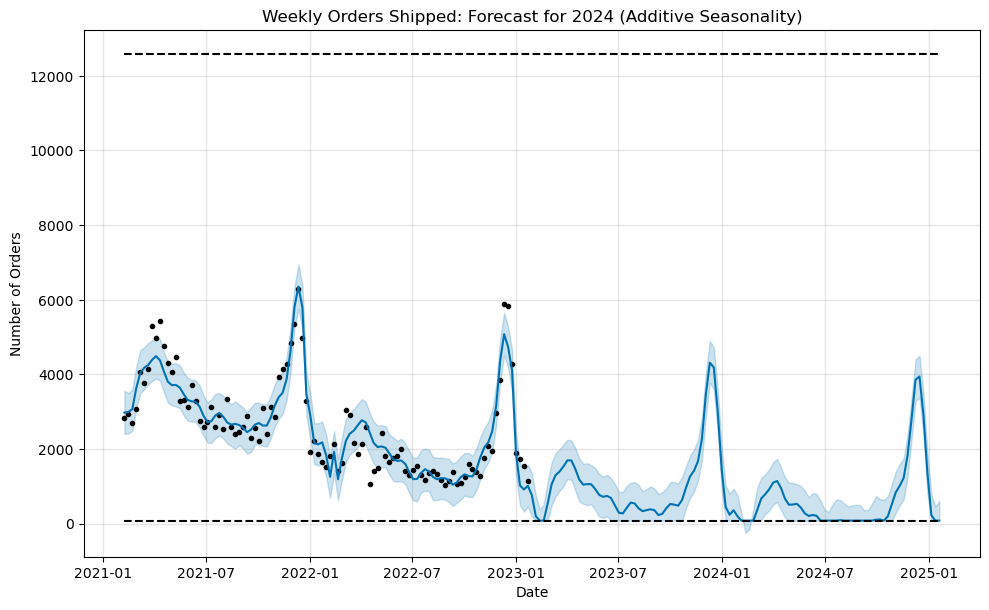

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

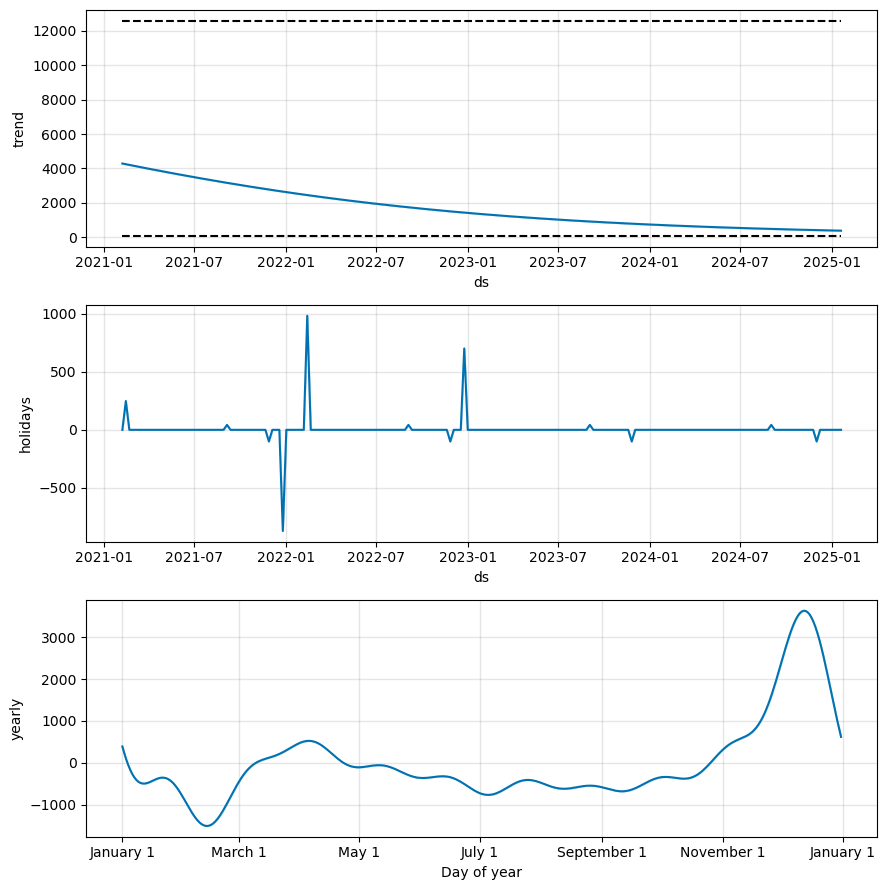

In [32]:
# 2. Resample to Weekly (W) to get weekly aggregate of orders
# We switch to weekly so holidays are not absorbed by quarterly seasonality
weekly_series = df_orders.resample('W', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
weekly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
weekly_series['ds'] = weekly_series['ds'].dt.tz_localize(None)

# FIX: Drop the final row because it is likely an incomplete week (e.g., ends on a Tuesday)
# This prevents the model from learning an artificial massive drop at the end of the training data
weekly_series = weekly_series.iloc[:-1].copy()

# Add cap and floor columns for logistic growth
# We set the floor to a small baseline to represent the remaining userbase, preventing negative predictions
baseline_orders = weekly_series['y'].mean() * 0.03
weekly_series['floor'] = baseline_orders

# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = weekly_series['y'].max()
weekly_series['cap'] = max_orders * 2

# Define the retail holidays for Fingerhut's specific inventory (2021-2024)
holidays_data = {
    'holiday': [
        'Black Friday', 'Black Friday', 'Black Friday', 'Black Friday',
        'Cyber Monday', 'Cyber Monday', 'Cyber Monday', 'Cyber Monday',
        'Christmas', 'Christmas', 'Christmas', 'Christmas',
        'Valentines', 'Valentines', 'Valentines', 'Valentines',
        'Labor Day', 'Labor Day', 'Labor Day', 'Labor Day'
    ],
    'ds': pd.to_datetime([
        '2021-11-26', '2022-11-25', '2023-11-24', '2024-11-29', # Black Friday
        '2021-11-29', '2022-11-28', '2023-11-27', '2024-12-02', # Cyber Monday
        '2021-12-25', '2022-12-25', '2023-12-25', '2024-12-25', # Christmas
        '2021-02-14', '2022-02-14', '2023-02-14', '2024-02-14', # Valentines (Jewelry)
        '2021-09-06', '2022-09-05', '2023-09-04', '2024-09-02'  # Labor Day (Appliances)
    ]),
    'lower_window': -3, # Extends the holiday effect 3 days before
    'upper_window': 3   # Extends the holiday effect 3 days after to match the weekly grouping
}
retail_holidays = pd.DataFrame(holidays_data)

# 3. Fit the model using logistic growth, ADDITIVE seasonality, and retail holidays
# We forcefully set yearly_seasonality=True because our dataset is just barely under 730 days
m = Prophet(
    growth='logistic', 
    seasonality_mode='additive', 
    holidays=retail_holidays,
    yearly_seasonality=True
)
m.fit(weekly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 104 weeks (2 years) into the future
future = m.make_future_dataframe(periods=104, freq='W')

# The future dataframe also needs the cap and floor defined
future['floor'] = baseline_orders
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Force any stray predictions in the confidence intervals to respect our baseline floor
forecast['yhat'] = forecast['yhat'].clip(lower=baseline_orders)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=baseline_orders)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Weekly Orders Shipped: Forecast for 2024 (Additive Seasonality)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

11:50:37 - cmdstanpy - INFO - Chain [1] start processing
11:50:37 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


        ds   pred_mean  ci95_lower  ci95_upper
2024-01-07  773.590878  539.952203 1112.414877
2024-01-14  680.509864  479.568731  964.608921
2024-01-21  651.915284  443.353411  931.967888
2024-01-28  604.543720  422.345898  887.718620
2024-02-04  529.984200  370.026518  754.079620
2024-02-11  478.669481  332.556411  704.271006
2024-02-18  486.893345  346.109714  708.072020
2024-02-25  553.861552  390.211107  817.380809
2024-03-03  644.290318  449.560429  905.838497
2024-03-10  709.119844  484.332993 1034.025394
2024-03-17  733.703219  494.556287 1053.026338
2024-03-24  738.863667  520.517096 1081.479115
2024-03-31  734.450539  501.833764 1066.935875
2024-04-07  708.604969  496.779751 1005.283012
2024-04-14  660.840459  472.386957  963.885440
2024-04-21  617.219169  429.018124  888.601039
2024-04-28  602.382517  424.504613  880.132208
2024-05-05  613.796320  420.589682  886.289393
2024-05-12  624.639686  432.523962  888.699018
2024-05-19  612.643797  433.289633  906.228210
2024-05-26  5

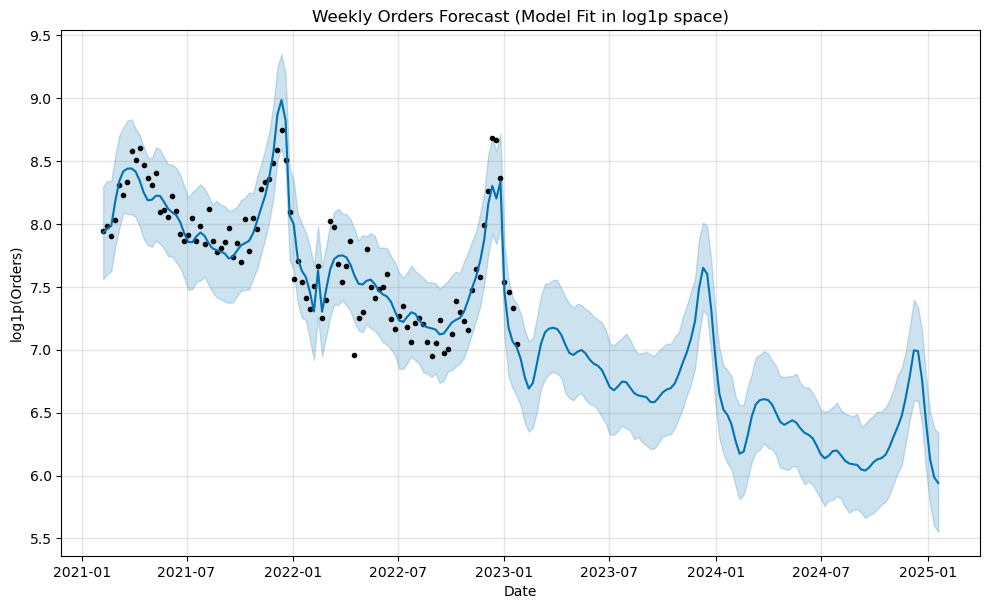

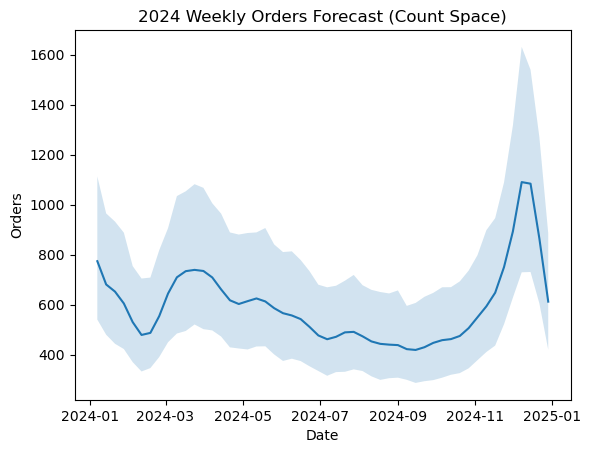

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

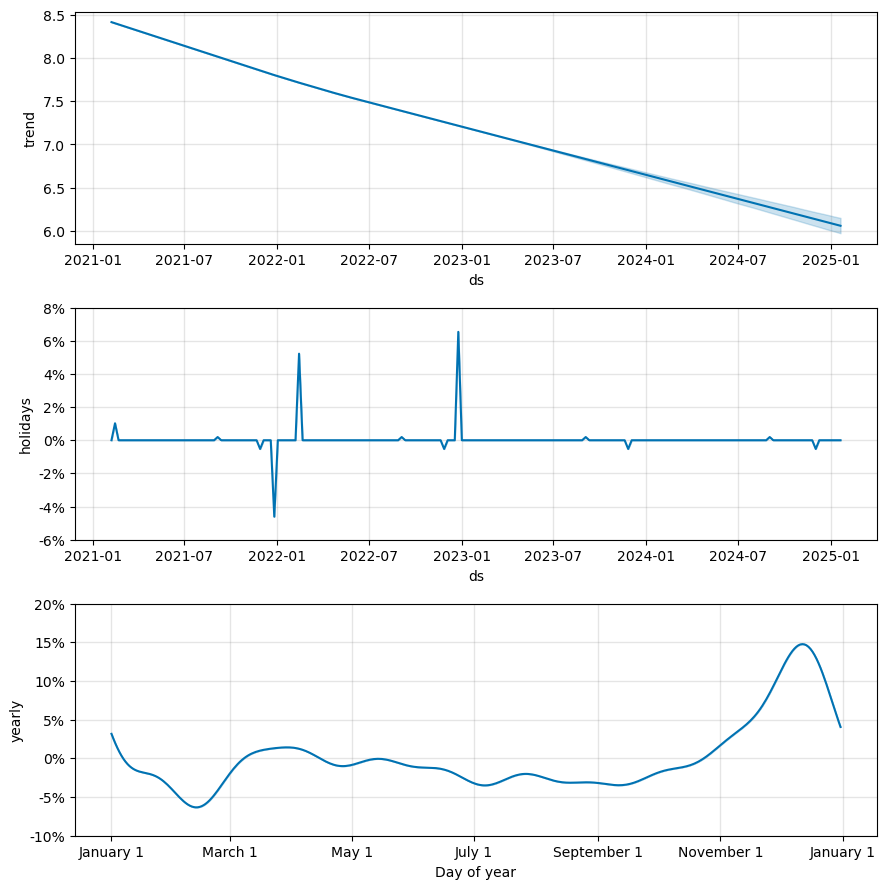

In [33]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# weekly_series must already exist with columns: ds, y
# retail_holidays must already exist

weekly = weekly_series.copy()

# 1) Transform target to stabilize variance and avoid negative forecasts
weekly['y_log'] = np.log1p(weekly['y'])

# Prophet expects target column to be named y
weekly_for_prophet = weekly[['ds', 'y_log']].rename(columns={'y_log': 'y'}).copy()

# 2) Fit model
m = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    holidays=retail_holidays,
    changepoint_prior_scale=0.01,   # smoother trend
    seasonality_prior_scale=5,
    holidays_prior_scale=5,
    interval_width=0.95
)
m.fit(weekly_for_prophet)

# 3) Forecast forward
future = m.make_future_dataframe(periods=104, freq='W')
forecast_log = m.predict(future)

# 4) Invert transform back to counts
forecast = forecast_log.copy()
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[col] = np.expm1(forecast[col])

# counts should not be negative after inverse, but clip just in case
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[col] = forecast[col].clip(lower=0)

# 5) Report 2024 predictions (mean + 95% CI)
pred_2024 = forecast.loc[
    (forecast['ds'] >= '2024-01-01') & (forecast['ds'] < '2025-01-01'),
    ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
].copy()

pred_2024.rename(columns={
    'yhat': 'pred_mean',
    'yhat_lower': 'ci95_lower',
    'yhat_upper': 'ci95_upper'
}, inplace=True)

print(pred_2024.to_string(index=False))

summary_2024 = pd.Series({
    "avg_weekly_pred_mean_2024": pred_2024['pred_mean'].mean(),
    "avg_weekly_ci95_lower_2024": pred_2024['ci95_lower'].mean(),
    "avg_weekly_ci95_upper_2024": pred_2024['ci95_upper'].mean(),
    "total_predicted_orders_2024": pred_2024['pred_mean'].sum()
})
print("\n2024 prediction summary:")
print(summary_2024)

pred_2024.to_csv("weekly_predictions_2024_with_ci95_log_model.csv", index=False)

# 6) Plots
fig1 = m.plot(forecast_log)  # plot in log space (Prophet internal)
plt.title('Weekly Orders Forecast (Model Fit in log1p space)')
plt.xlabel('Date')
plt.ylabel('log1p(Orders)')
plt.show()

# Optional: plot in original count space
plt.figure()
plt.plot(pred_2024['ds'], pred_2024['pred_mean'])
plt.fill_between(pred_2024['ds'], pred_2024['ci95_lower'], pred_2024['ci95_upper'], alpha=0.2)
plt.title('2024 Weekly Orders Forecast (Count Space)')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.show()

fig2 = m.plot_components(forecast_log)
plt.show()


### Cross Validation Method

In [34]:
from itertools import product
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd

# Build training data for Prophet (log model)
train_df = weekly_series[['ds', 'y']].copy()
train_df['y'] = np.log1p(train_df['y'])

# A small hyperparameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.02, 0.05, 0.1],
    'seasonality_prior_scale': [1.0, 5.0, 10.0],
    'holidays_prior_scale': [1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

results = []

for params in all_params:
    # m_cv = Prophet(
    #     growth='linear',
    #     yearly_seasonality=True,
    #     holidays=retail_holidays,
    #     interval_width=0.95,
    #     changepoint_prior_scale=params['changepoint_prior_scale'],
    #     seasonality_prior_scale=params['seasonality_prior_scale'],
    #     holidays_prior_scale=params['holidays_prior_scale'],
    #     seasonality_mode=params['seasonality_mode']
    # )
    m_cv = Prophet(
        growth='linear',
        seasonality_mode='multiplicative',
        yearly_seasonality=True,
        holidays=retail_holidays,
        changepoint_prior_scale=0.02,   # smoother trend
        seasonality_prior_scale=5,
        holidays_prior_scale=5,
        interval_width=0.95
    )

    m_cv.add_seasonality(
    name='quarterly',
    period=365.25/4,
    fourier_order=5
)
    m_cv.fit(train_df)

    df_cv = cross_validation(
        m_cv,
        initial='365 days',
        period='90 days',
        horizon='180 days'
    )

    df_p = performance_metrics(df_cv)

    # This MSE is in log space since the model was fit in log space
    mean_mse = df_p['mse'].mean()

    results.append({
        **params,
        'cv_mse_log_space': mean_mse,
        'cv_rmse_log_space': df_p['rmse'].mean()
    })

results_df = pd.DataFrame(results).sort_values('cv_mse_log_space')
print(results_df.head(10).to_string(index=False))

best_params = results_df.iloc[0].to_dict()
print("\nBest params:")
print(best_params)


11:50:37 - cmdstanpy - INFO - Chain [1] start processing
11:50:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]11:50:37 - cmdstanpy - INFO - Chain [1] start processing
11:50:38 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  1.92it/s]11:50:38 - cmdstanpy - INFO - Chain [1] start processing
11:50:38 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  2.11it/s]
11:50:38 - cmdstanpy - INFO - Chain [1] start processing
11:50:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]11:50:38 - cmdstanpy - INFO - Chain [1] start processing
11:50:39 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  1.92it/s]11:50:39 - cmdsta

 changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale seasonality_mode  cv_mse_log_space  cv_rmse_log_space
                    0.01                      1.0                   1.0         additive          0.086856           0.219883
                    0.05                      1.0                  10.0         additive          0.086856           0.219883
                    0.05                      1.0                  10.0   multiplicative          0.086856           0.219883
                    0.05                      5.0                   1.0         additive          0.086856           0.219883
                    0.05                      5.0                   1.0   multiplicative          0.086856           0.219883
                    0.05                      5.0                  10.0         additive          0.086856           0.219883
                    0.05                      5.0                  10.0   multiplicative          0.086856           0

In [35]:
df_cv_counts = df_cv.copy()
df_cv_counts['y_count'] = np.expm1(df_cv_counts['y'])
df_cv_counts['yhat_count'] = np.expm1(df_cv_counts['yhat'])

mse_count_space = np.mean((df_cv_counts['y_count'] - df_cv_counts['yhat_count'])**2)
print("CV MSE in count space:", mse_count_space)


CV MSE in count space: 691908.3194075581


### Feature selection

In [36]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd
from itertools import product

train_df = weekly_series[['ds','y']].copy()
train_df['y'] = np.log1p(train_df['y'])

grid = {
    "seasonality_mode": ["additive", "multiplicative"],
    "use_quarterly": [False, True],
    "changepoint_prior_scale": [0.01, 0.02, 0.05],
    "use_holidays": [True, False],  # set to [True] if you want fewer runs
}

rows = []

for seasonality_mode, use_quarterly, cps, use_holidays in product(
    grid["seasonality_mode"],
    grid["use_quarterly"],
    grid["changepoint_prior_scale"],
    grid["use_holidays"]
):
    m = Prophet(
        growth="linear",
        yearly_seasonality=True,
        seasonality_mode=seasonality_mode,
        holidays=retail_holidays if use_holidays else None,
        changepoint_prior_scale=cps,
        seasonality_prior_scale=5,
        holidays_prior_scale=5,
        interval_width=0.95
    )

    if use_quarterly:
        m.add_seasonality(name="quarterly", period=365.25/4, fourier_order=5)

    m.fit(train_df)

    df_cv = cross_validation(m, initial="365 days", period="90 days", horizon="180 days")
    df_cv_tmp = df_cv.copy()
    df_cv_tmp["y_count"] = np.expm1(df_cv_tmp["y"])
    df_cv_tmp["yhat_count"] = np.expm1(df_cv_tmp["yhat"])
    mse_count = np.mean((df_cv_tmp["y_count"] - df_cv_tmp["yhat_count"])**2)
    rmse_count = np.sqrt(mse_count)

    df_p = performance_metrics(df_cv)

    rows.append({
        "seasonality_mode": seasonality_mode,
        "use_quarterly": use_quarterly,
        "changepoint_prior_scale": cps,
        "use_holidays": use_holidays,
        "mse_log": df_p["mse"].mean(),
        "rmse_log": df_p["rmse"].mean()
    })

results = pd.DataFrame(rows).sort_values("mse_log")
print(results.head(10).to_string(index=False))


11:51:28 - cmdstanpy - INFO - Chain [1] start processing
11:51:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]11:51:28 - cmdstanpy - INFO - Chain [1] start processing
11:51:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  3.35it/s]11:51:28 - cmdstanpy - INFO - Chain [1] start processing
11:51:29 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  3.46it/s]
11:51:29 - cmdstanpy - INFO - Chain [1] start processing
11:51:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]11:51:29 - cmdstanpy - INFO - Chain [1] start processing
11:51:29 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  3.83it/s]11:51:29 - cmdsta

seasonality_mode  use_quarterly  changepoint_prior_scale  use_holidays  mse_log  rmse_log
        additive           True                     0.01         False 0.069624  0.200739
        additive           True                     0.02         False 0.069669  0.200765
        additive          False                     0.02         False 0.076585  0.224178
        additive          False                     0.01         False 0.077386  0.225050
  multiplicative           True                     0.01         False 0.078167  0.210797
  multiplicative           True                     0.02         False 0.078320  0.210818
        additive           True                     0.02          True 0.078916  0.210684
        additive           True                     0.01          True 0.079160  0.210404
        additive          False                     0.01          True 0.081921  0.233040
        additive          False                     0.02          True 0.082229  0.233389


11:51:43 - cmdstanpy - INFO - Chain [1] start processing
11:51:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]11:51:43 - cmdstanpy - INFO - Chain [1] start processing
11:51:43 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  5.39it/s]11:51:43 - cmdstanpy - INFO - Chain [1] start processing
11:51:44 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


Cross-Validated MSE (count space): 579543.880979092
Cross-Validated RMSE (count space): 761.2777948811406
        ds   pred_mean  ci95_lower  ci95_upper
2024-01-07  877.051878  626.202669 1211.373929
2024-01-14  720.014766  503.600056 1036.665725
2024-01-21  590.805870  412.962798  822.625667
2024-01-28  559.217679  382.771185  779.854026
2024-02-04  571.061524  409.767970  821.200395
2024-02-11  561.385459  395.466026  809.476424
2024-02-18  497.325076  352.005751  685.846858
2024-02-25  516.258483  366.966263  720.399022
2024-03-03  685.546271  500.298417  987.731255
2024-03-10  810.115511  567.520857 1178.769637
2024-03-17  795.168514  554.296512 1107.650813
2024-03-24  738.912292  526.183044 1047.564398
2024-03-31  745.138221  531.676726 1047.293050
2024-04-07  818.812325  575.691663 1148.252533
2024-04-14  732.977805  520.704126 1031.358632
2024-04-21  584.810480  407.369113  840.645944
2024-04-28  570.826981  398.735349  818.631553
2024-05-05  663.311791  470.325213  939.198390
2

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


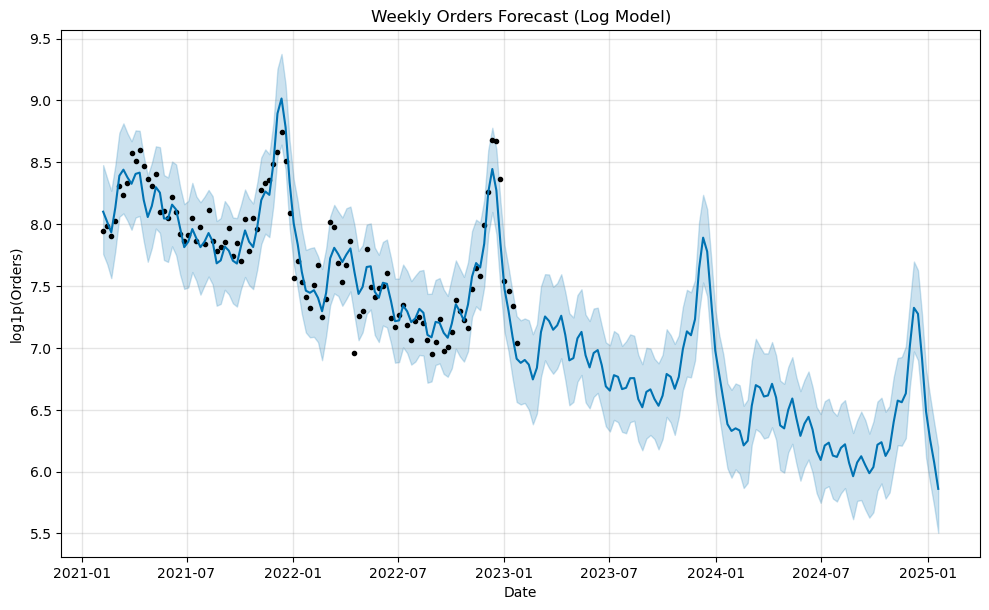

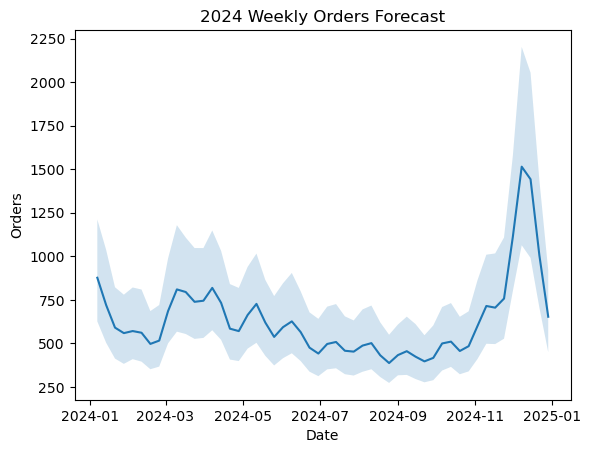

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

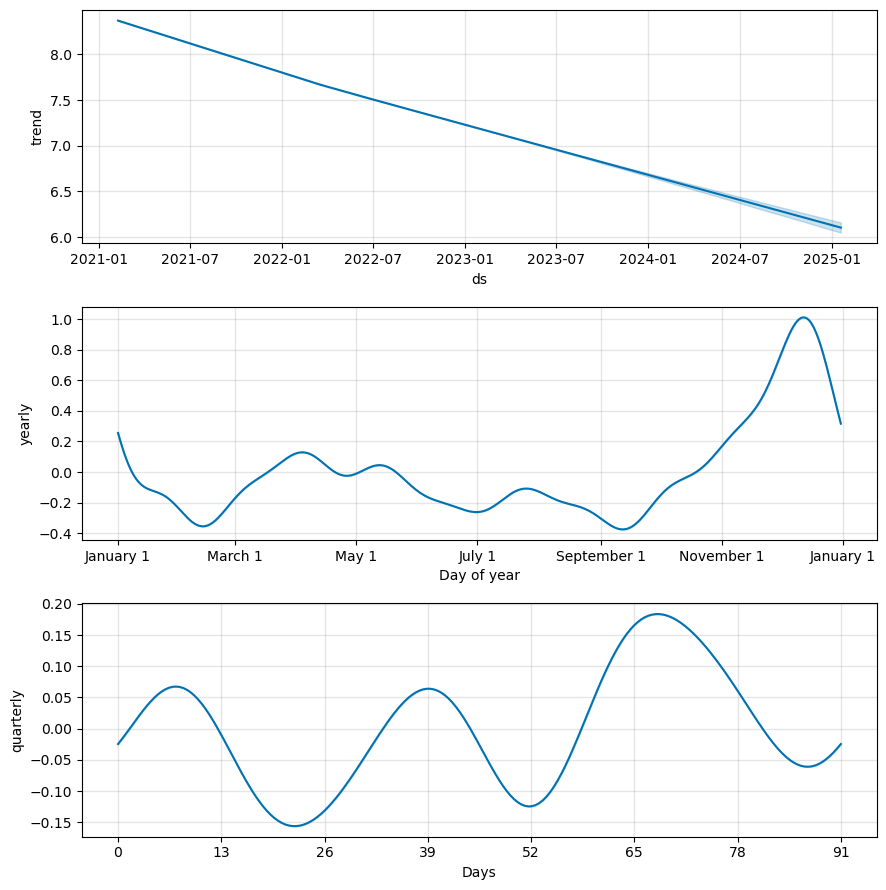

In [37]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Prepare data (log transform)
# -----------------------------

train_df = weekly_series[['ds', 'y']].copy()
train_df['y'] = np.log1p(train_df['y'])

# -----------------------------
# 2. Define final Prophet model
# -----------------------------

m = Prophet(
    growth='linear',
    seasonality_mode='additive',
    yearly_seasonality=True,
    changepoint_prior_scale=0.01,
    seasonality_prior_scale=5,
    interval_width=0.95
)

# Add quarterly seasonality
m.add_seasonality(
    name='quarterly',
    period=365.25 / 4,
    fourier_order=5
)

# Fit model
m.fit(train_df)

# -----------------------------
# 3. Cross-validation evaluation
# -----------------------------

df_cv = cross_validation(
    m,
    initial='365 days',
    period='90 days',
    horizon='180 days'
)

df_p = performance_metrics(df_cv)

# Convert CV predictions back to count space
df_cv_counts = df_cv.copy()
df_cv_counts['y_count'] = np.expm1(df_cv_counts['y'])
df_cv_counts['yhat_count'] = np.expm1(df_cv_counts['yhat'])

mse_count = np.mean((df_cv_counts['y_count'] - df_cv_counts['yhat_count'])**2)
rmse_count = np.sqrt(mse_count)

print("Cross-Validated MSE (count space):", mse_count)
print("Cross-Validated RMSE (count space):", rmse_count)

# -----------------------------
# 4. Forecast 2024
# -----------------------------

future = m.make_future_dataframe(periods=104, freq='W')
forecast_log = m.predict(future)

# Convert forecast back to counts
forecast = forecast_log.copy()
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[col] = np.expm1(forecast[col]).clip(lower=0)

# Extract 2024 predictions
pred_2024 = forecast.loc[
    (forecast['ds'] >= '2024-01-01') &
    (forecast['ds'] < '2025-01-01'),
    ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
].copy()

pred_2024.rename(columns={
    'yhat': 'pred_mean',
    'yhat_lower': 'ci95_lower',
    'yhat_upper': 'ci95_upper'
}, inplace=True)

print(pred_2024.to_string(index=False))

# -----------------------------
# 5. Plot results
# -----------------------------

fig1 = m.plot(forecast_log)
plt.title('Weekly Orders Forecast (Log Model)')
plt.xlabel('Date')
plt.ylabel('log1p(Orders)')
plt.show()

plt.figure()
plt.plot(pred_2024['ds'], pred_2024['pred_mean'])
plt.fill_between(
    pred_2024['ds'],
    pred_2024['ci95_lower'],
    pred_2024['ci95_upper'],
    alpha=0.2
)
plt.title('2024 Weekly Orders Forecast')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.show()

fig2 = m.plot_components(forecast_log)
plt.show()


In [38]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def prophet_forecast_with_scale(
    series_df: pd.DataFrame,
    freq: str = "W",                      # "D", "W", "M", "Q"
    periods: int | None = None,           # if None, set sensible default by freq
    report_year: int = 2024,
    log_transform: bool = True,
    clip_nonnegative: bool = True,
    interval_width: float = 0.95,
    changepoint_prior_scale: float = 0.01,
    seasonality_prior_scale: float = 5.0,
    seasonality_mode: str = "additive",   # "additive" or "multiplicative"
    add_quarterly_seasonality: bool = True,
    quarterly_fourier_order: int = 5,
    cv_initial: str | None = None,
    cv_period: str | None = None,
    cv_horizon: str | None = None,
):
    """
    series_df must have columns: ['ds','y'] already aggregated at the desired grain OR raw.
    This function:
      1) optionally re-resamples to freq (if ds not already on that freq, it will aggregate)
      2) fits Prophet
      3) runs CV and prints MSE/RMSE in count space
      4) forecasts forward and prints report_year predictions with CI
      5) plots forecast + components + report_year chart
    """

    # -----------------------------
    # 0) Resample/aggregate to desired frequency
    # -----------------------------
    df = series_df[['ds', 'y']].copy()
    df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)

    # If the input is event-level counts already aggregated, resampling with sum is safe.
    # If your df has one row per event, set y=1 before calling this function.
    df = (
        df.set_index('ds')
          .resample(freq)['y']
          .sum()
          .reset_index()
    )

    # Drop last row (often incomplete period)
    if len(df) > 1:
        df = df.iloc[:-1].copy()

    # -----------------------------
    # 1) Prepare training data
    # -----------------------------
    train_df = df.copy()
    if log_transform:
        train_df['y'] = np.log1p(train_df['y'])

    # -----------------------------
    # 2) Sensible defaults by frequency
    # -----------------------------
    if periods is None:
        periods = {"D": 730, "W": 104, "M": 24, "Q": 8}.get(freq, 104)

    if cv_initial is None or cv_period is None or cv_horizon is None:
        defaults = {
            "D": ("365 days", "90 days", "180 days"),
            "W": ("365 days", "90 days", "180 days"),
            "M": ("365 days", "30 days", "90 days"),
            "Q": ("730 days", "90 days", "180 days"),
        }
        d_init, d_period, d_horizon = defaults.get(freq, ("365 days", "90 days", "180 days"))
        cv_initial = cv_initial or d_init
        cv_period = cv_period or d_period
        cv_horizon = cv_horizon or d_horizon

    # -----------------------------
    # 3) Define and fit model
    # -----------------------------
    m = Prophet(
        growth='linear',
        seasonality_mode=seasonality_mode,
        yearly_seasonality=True,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        interval_width=interval_width
    )

    if add_quarterly_seasonality:
        m.add_seasonality(
            name='quarterly',
            period=365.25 / 4,
            fourier_order=quarterly_fourier_order
        )

    m.fit(train_df)

    # -----------------------------
    # 4) Cross-validation evaluation
    # -----------------------------
    df_cv = cross_validation(
        m,
        initial=cv_initial,
        period=cv_period,
        horizon=cv_horizon
    )
    df_p = performance_metrics(df_cv)

    # Convert CV back to count space if log-transformed
    if log_transform:
        df_cv_counts = df_cv.copy()
        df_cv_counts['y_count'] = np.expm1(df_cv_counts['y'])
        df_cv_counts['yhat_count'] = np.expm1(df_cv_counts['yhat'])
        mse_count = np.mean((df_cv_counts['y_count'] - df_cv_counts['yhat_count'])**2)
        rmse_count = np.sqrt(mse_count)
    else:
        mse_count = df_p['mse'].mean()
        rmse_count = df_p['rmse'].mean()

    print(f"Frequency: {freq}")
    print("Cross-Validated MSE (count space):", mse_count)
    print("Cross-Validated RMSE (count space):", rmse_count)

    # -----------------------------
    # 5) Forecast forward
    # -----------------------------
    future = m.make_future_dataframe(periods=periods, freq=freq)
    forecast_pred = m.predict(future)

    # Convert forecast back to count space if log-transformed
    forecast = forecast_pred.copy()
    if log_transform:
        for col in ['yhat', 'yhat_lower', 'yhat_upper']:
            forecast[col] = np.expm1(forecast[col])

    if clip_nonnegative:
        for col in ['yhat', 'yhat_lower', 'yhat_upper']:
            forecast[col] = forecast[col].clip(lower=0)

    # Extract report_year predictions
    start = pd.Timestamp(f'{report_year}-01-01')
    end = pd.Timestamp(f'{report_year+1}-01-01')
    pred_year = forecast.loc[
        (forecast['ds'] >= start) & (forecast['ds'] < end),
        ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
    ].copy()

    pred_year.rename(columns={
        'yhat': 'pred_mean',
        'yhat_lower': 'ci95_lower',
        'yhat_upper': 'ci95_upper'
    }, inplace=True)

    print(f"\n{report_year} Predictions with {int(interval_width*100)}% CI ({freq}):")
    print(pred_year.to_string(index=False))

    # -----------------------------
    # 6) Plots
    # -----------------------------
    # Prophet's built-in plot (in model space if log_transform else count space)
    fig1 = m.plot(forecast_pred)
    plt.title(f'Orders Forecast (freq={freq}, model_space={"log" if log_transform else "count"})')
    plt.xlabel('Date')
    plt.ylabel('log1p(Orders)' if log_transform else 'Orders')
    plt.show()

    # Clean plot in count space for report_year
    plt.figure()
    plt.plot(pred_year['ds'], pred_year['pred_mean'])
    plt.fill_between(pred_year['ds'], pred_year['ci95_lower'], pred_year['ci95_upper'], alpha=0.2)
    plt.title(f'{report_year} Orders Forecast (freq={freq}, count space)')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.show()

    # Components plot (still in model space)
    fig2 = m.plot_components(forecast_pred)
    plt.show()

    return {
        "model": m,
        "train_series": df,           # resampled series in count space
        "forecast": forecast,         # forecast in count space
        "pred_year": pred_year,       # year slice in count space
        "mse": float(mse_count),
        "rmse": float(rmse_count),
        "cv_metrics": df_p
    }


/var/folders/3g/fzqltvr90_11xv3v1sxb4f2m0000gn/T/ipykernel_73909/1463039648.py:44: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(freq)['y']
11:51:44 - cmdstanpy - INFO - Chain [1] start processing
11:51:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/8 [00:00<?, ?it/s]11:51:45 - cmdstanpy - INFO - Chain [1] start processing
11:51:45 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 1/8 [00:00<00:01,  4.60it/s]11:51:45 - cmdstanpy - INFO - Chain [1] start processing
11:51:45 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 2/8 [00:00<00:01,  4.67it/s]11:51:45 - cmdstanpy - INFO - Chain [1] start processing
11:51:45 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 3/8 [00:00<00:01,  4.77it/s]11:51:45 - cmdstanpy - INFO - Chain [1] start processing
11:51:52 -

Frequency: M
Cross-Validated MSE (count space): 2663880028.419693
Cross-Validated RMSE (count space): 51612.789388093464

2024 Predictions with 95% CI (M):
        ds  pred_mean  ci95_lower  ci95_upper
2024-01-31 248.878686  246.790807  251.001369
2024-02-29   0.000000    0.000000    0.000000
2024-03-31   0.000000    0.000000    0.000000
2024-04-30   0.000000    0.000000    0.000000
2024-05-31   0.000000    0.000000    0.000000
2024-06-30   0.000000    0.000000    0.000000
2024-07-31   0.000000    0.000000    0.000000
2024-08-31   0.000000    0.000000    0.000000
2024-09-30   0.000000    0.000000    0.000000
2024-10-31   0.000000    0.000000    0.000000
2024-11-30   0.000000    0.000000    0.000000
2024-12-31   0.000000    0.000000    0.000000



/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


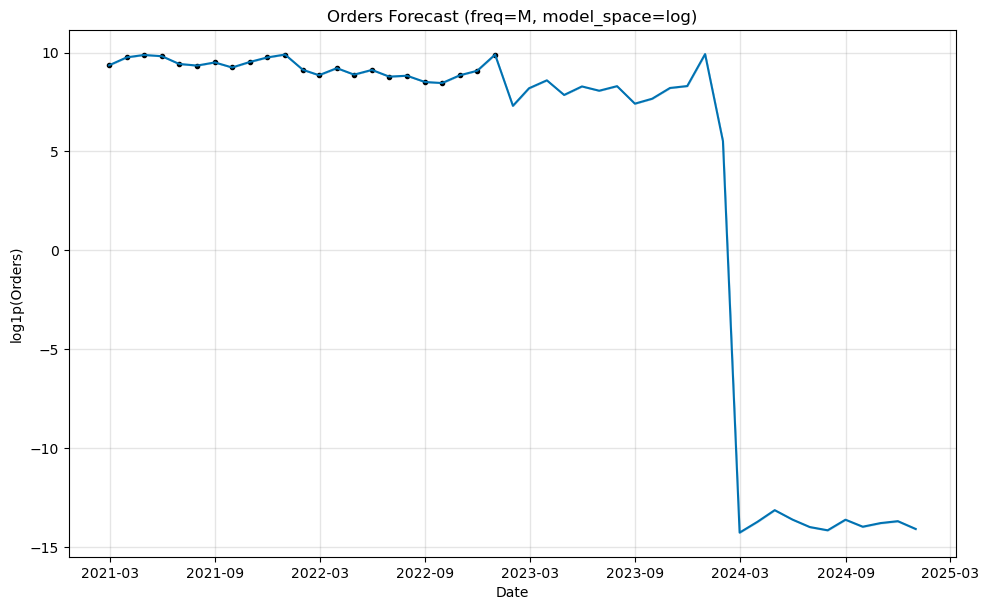

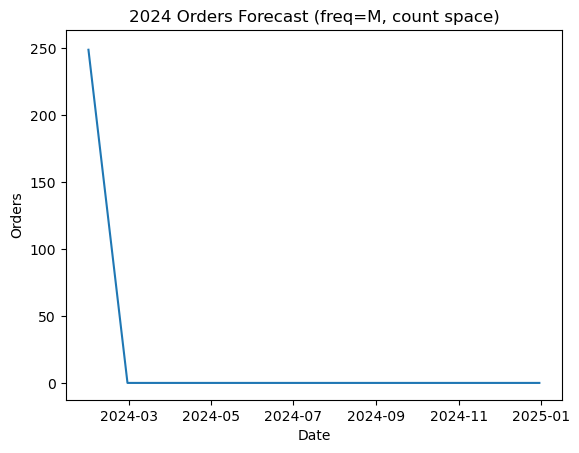

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

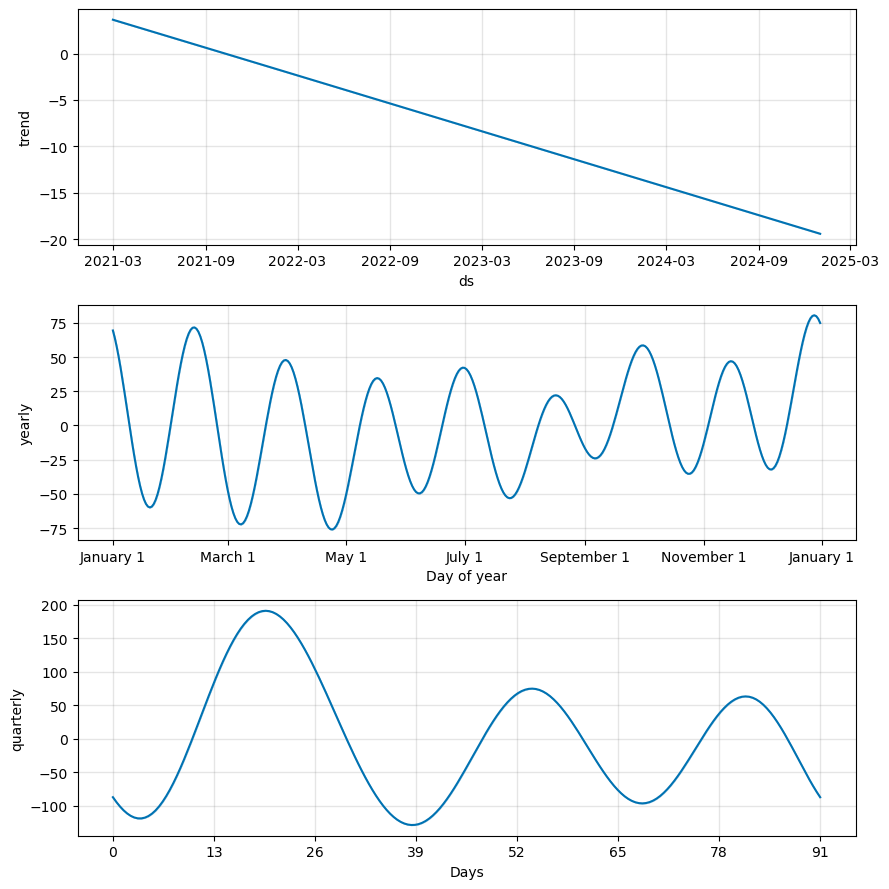

In [39]:
out_monthly = prophet_forecast_with_scale(weekly_series, freq="M", cv_horizon="90 days")

11:51:56 - cmdstanpy - INFO - Chain [1] start processing
11:51:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]11:51:56 - cmdstanpy - INFO - Chain [1] start processing
11:51:56 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]11:51:56 - cmdstanpy - INFO - Chain [1] start processing
11:51:56 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


Frequency: W
Cross-Validated MSE (count space): 579389.133236536
Cross-Validated RMSE (count space): 761.1761512531353

2024 Predictions with 95% CI (W):
        ds   pred_mean  ci95_lower  ci95_upper
2024-01-07  857.960424  594.841620 1227.231541
2024-01-14  690.932214  487.098777  979.414139
2024-01-21  548.106616  388.643905  778.164349
2024-01-28  522.775402  366.503780  724.856355
2024-02-04  548.793454  393.811119  773.034867
2024-02-11  545.516048  377.555848  770.980249
2024-02-18  486.942612  340.610126  714.552580
2024-02-25  502.492294  351.811903  685.410589
2024-03-03  663.777893  476.458078  931.530903
2024-03-10  786.248219  565.571881 1118.861390
2024-03-17  772.426541  544.740385 1089.704101
2024-03-24  720.546220  502.450330 1021.400801
2024-03-31  722.299604  502.095597 1030.556367
2024-04-07  795.453764  555.692564 1132.598528
2024-04-14  715.631583  507.209523 1009.630025
2024-04-21  563.891523  393.457764  816.640752
2024-04-28  554.286287  383.334847  768.863386


/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


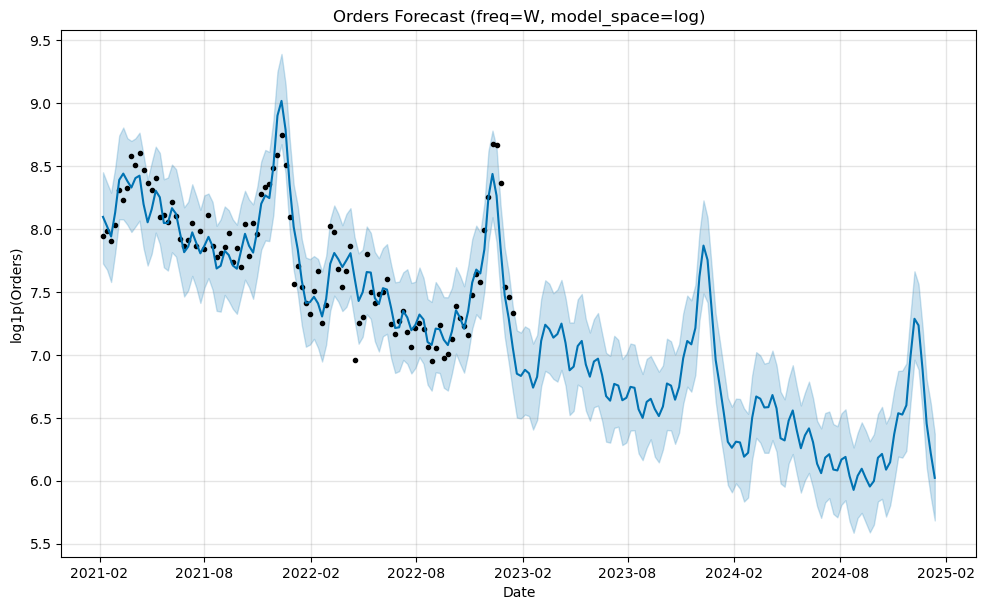

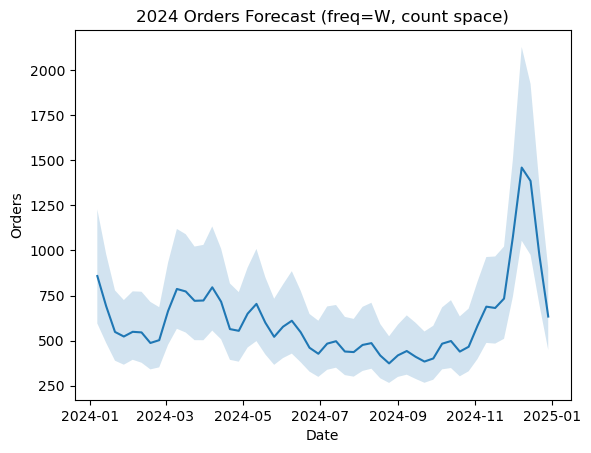

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

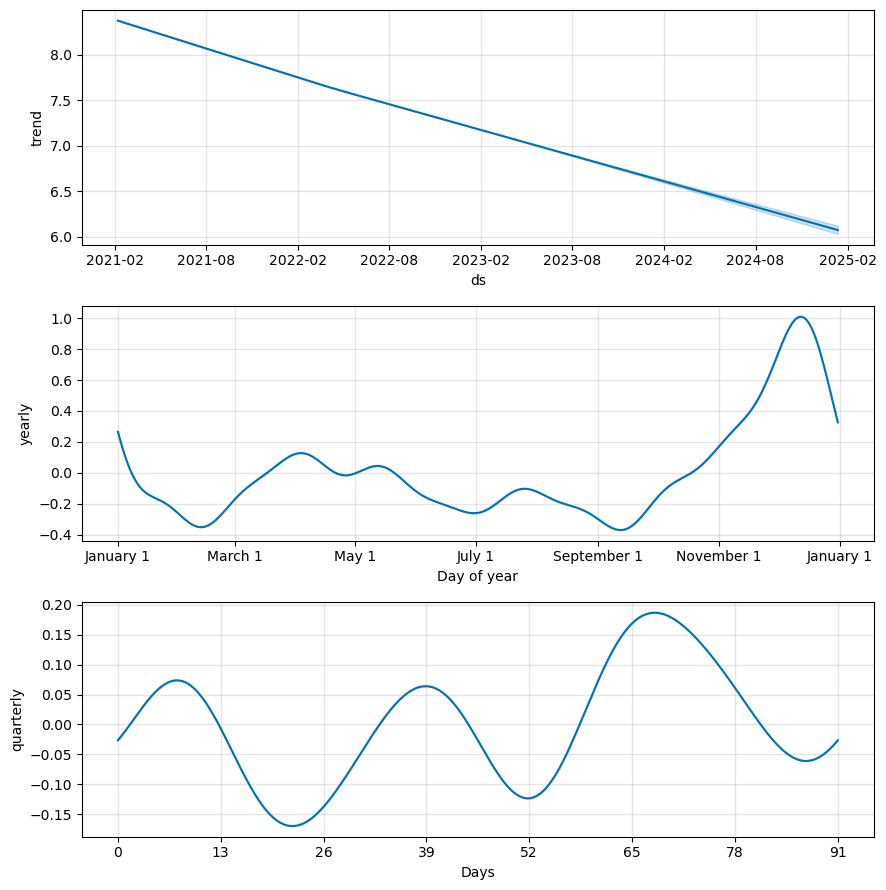

In [40]:
out_weekly = prophet_forecast_with_scale(weekly_series, freq="W")


In [41]:
from itertools import product
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import numpy as np

def tune_monthly_prophet_smoothness(
    df_orders: pd.DataFrame,
    timestamp_col: str = "event_timestamp",
    use_log1p: bool = False,                 # recommend False for monthly unless you really want it
    add_quarterly_seasonality: bool = True,
    quarterly_fourier_order: int = 5,
    interval_width: float = 0.95,
    # CV windows for monthly (adjust if you have lots of history)
    cv_initial: str = "365 days",
    cv_period: str = "30 days",
    cv_horizon: str = "90 days",
    # Hyperparameter grid (smoothness)
    changepoint_prior_scale_grid = (0.001, 0.01, 0.02, 0.05, 0.1),
    seasonality_prior_scale_grid = (0.5, 1.0, 5.0, 10.0),
    seasonality_mode_grid = ("additive", "multiplicative"),
    drop_last_row: bool = True,
):
    # -----------------------------
    # 1) Monthly aggregation
    # -----------------------------
    monthly_series = (
        df_orders
        .resample("M", on=timestamp_col)
        .size()
        .reset_index(name="y")
        .rename(columns={timestamp_col: "ds"})
    )
    monthly_series["ds"] = pd.to_datetime(monthly_series["ds"]).dt.tz_localize(None)
    if drop_last_row and len(monthly_series) > 1:
        monthly_series = monthly_series.iloc[:-1].copy()

    train_df = monthly_series[["ds", "y"]].copy()
    if use_log1p:
        train_df["y"] = np.log1p(train_df["y"])

    # -----------------------------
    # 2) Grid search with CV
    # -----------------------------
    results = []
    combos = list(product(changepoint_prior_scale_grid, seasonality_prior_scale_grid, seasonality_mode_grid))

    for cps, sps, smode in combos:
        m = Prophet(
            growth="linear",
            yearly_seasonality=True,
            seasonality_mode=smode,
            changepoint_prior_scale=float(cps),
            seasonality_prior_scale=float(sps),
            interval_width=interval_width,
        )

        if add_quarterly_seasonality:
            m.add_seasonality(
                name="quarterly",
                period=365.25 / 4,
                fourier_order=quarterly_fourier_order,
            )

        m.fit(train_df)

        df_cv = cross_validation(
            m,
            initial=cv_initial,
            period=cv_period,
            horizon=cv_horizon,
        )

        # Count-space MSE/RMSE
        if use_log1p:
            y_true = np.expm1(df_cv["y"].values)
            y_pred = np.expm1(df_cv["yhat"].values)
        else:
            y_true = df_cv["y"].values
            y_pred = df_cv["yhat"].values

        mse = float(np.mean((y_true - y_pred) ** 2))
        rmse = float(np.sqrt(mse))

        results.append({
            "changepoint_prior_scale": float(cps),
            "seasonality_prior_scale": float(sps),
            "seasonality_mode": smode,
            "mse_count": mse,
            "rmse_count": rmse,
        })

    results_df = pd.DataFrame(results).sort_values("mse_count").reset_index(drop=True)
    best_params = results_df.iloc[0].to_dict()

    return results_df, best_params, monthly_series


## Changing weekly predictions into monthly ones

In [42]:

def weekly_forecast_to_monthly(forecast_weekly: pd.DataFrame) -> pd.DataFrame:
    """
    forecast_weekly must contain: ds, yhat, yhat_lower, yhat_upper
    Returns monthly totals by summing weekly predictions inside each month.

    Note: summing yhat_lower/upper is an approximation (assumes independence).
    For better monthly intervals, use the simulation method below.
    """
    f = forecast_weekly[['ds','yhat','yhat_lower','yhat_upper']].copy()
    f['ds'] = pd.to_datetime(f['ds']).dt.tz_localize(None)

    monthly = (
        f.set_index('ds')
         .resample('M')[['yhat','yhat_lower','yhat_upper']]
         .sum()
         .reset_index()
    )

    monthly.rename(columns={
        'yhat': 'pred_mean',
        'yhat_lower': 'ci95_lower_approx',
        'yhat_upper': 'ci95_upper_approx'
    }, inplace=True)

    return monthly


def weekly_forecast_to_monthly_ci_by_sim(
    m,
    future_weekly: pd.DataFrame,
    n_samples: int = 2000
) -> pd.DataFrame:
    """
    Uses Prophet predictive samples to get a proper monthly distribution, then takes 2.5% and 97.5% quantiles.
    Returns a monthly dataframe with pred_mean and 95% CI.

    Requirements:
    - You already fit model m on weekly data
    - future_weekly is the same dataframe you passed to m.predict (must have 'ds')
    """
    future_weekly = future_weekly.copy()
    future_weekly['ds'] = pd.to_datetime(future_weekly['ds']).dt.tz_localize(None)

    # predictive_samples returns a dict of arrays shaped [n_samples, n_timesteps] in most Prophet versions
    samples = m.predictive_samples(future_weekly)
    yhat_samps = samples['yhat']  # shape: (n_samples, T)

    ds = future_weekly['ds'].values
    samp_df = pd.DataFrame(yhat_samps.T, index=pd.to_datetime(ds))  # T x n_samples

    # aggregate each sample path to monthly totals
    monthly_samps = samp_df.resample('M').sum()

    # summarize
    pred_mean = monthly_samps.mean(axis=1)
    lower = monthly_samps.quantile(0.025, axis=1)
    upper = monthly_samps.quantile(0.975, axis=1)

    out = pd.DataFrame({
        'ds': monthly_samps.index,
        'pred_mean': pred_mean.values,
        'ci95_lower': lower.values,
        'ci95_upper': upper.values
    }).reset_index(drop=True)

    return out


In [43]:
def weekly_to_monthly_with_ci(
    m,
    periods: int = 104,
    start_date: str = "2023-01-01",
    end_date: str = "2024-12-31",
    is_log_model: bool = True,
    plot: bool = True
):
    # Weekly future grid
    future = m.make_future_dataframe(periods=periods, freq="W")
    future["ds"] = pd.to_datetime(future["ds"]).dt.tz_localize(None)

    # Predictive samples (Prophet version safe)
    try:
        samples = m.predictive_samples(future, n_samples=1000)
    except TypeError:
        samples = m.predictive_samples(future)

    yhat_samples = samples["yhat"]

    # Convert to count space
    if is_log_model:
        yhat_samples = np.expm1(yhat_samples)

    # Shape handling
    T = len(future)
    if yhat_samples.shape[0] == T:
        sim_df = pd.DataFrame(yhat_samples, index=future["ds"])
    elif yhat_samples.shape[1] == T:
        sim_df = pd.DataFrame(yhat_samples.T, index=future["ds"])
    else:
        raise ValueError(f"Unexpected yhat_samples shape {yhat_samples.shape} vs T={T}")

    # Aggregate to monthly
    monthly_sim = sim_df.resample("M").sum()

    monthly = pd.DataFrame({
        "ds": monthly_sim.index,
        "pred_mean": monthly_sim.mean(axis=1).values,
        "ci95_lower": monthly_sim.quantile(0.025, axis=1).values,
        "ci95_upper": monthly_sim.quantile(0.975, axis=1).values
    }).reset_index(drop=True)

    # 🔥 NEW: flexible date range instead of single year
    monthly_range = monthly[
        (monthly["ds"] >= pd.Timestamp(start_date)) &
        (monthly["ds"] <= pd.Timestamp(end_date))
    ].copy()

    if plot:
        plt.figure(figsize=(12,5))
        plt.plot(monthly_range["ds"], monthly_range["pred_mean"], marker="o", label="Predicted mean")
        plt.fill_between(
            monthly_range["ds"],
            monthly_range["ci95_lower"],
            monthly_range["ci95_upper"],
            alpha=0.2,
            label="95% CI"
        )
        plt.title(f"Monthly Orders Forecast ({start_date} to {end_date})")
        plt.xlabel("Date")
        plt.ylabel("Orders")
        plt.legend()
        plt.grid(True)
        plt.show()

    return monthly_range

In [44]:
def plot_monthly_history_plus_forecast(
    df_orders: pd.DataFrame,
    monthly_forecast_2024: pd.DataFrame,
    timestamp_col: str = "event_timestamp",
    title: str = "Monthly Orders: History + Forecast (from Weekly Model)",
):
    # Actual monthly history
    actual_monthly = (
        df_orders
        .resample("M", on=timestamp_col)
        .size()
        .reset_index(name="actual")
        .rename(columns={timestamp_col: "ds"})
    )
    actual_monthly["ds"] = pd.to_datetime(actual_monthly["ds"]).dt.tz_localize(None)

    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(actual_monthly["ds"], actual_monthly["actual"], label="Actual monthly (history)", marker="o")

    plt.plot(monthly_forecast_2024["ds"], monthly_forecast_2024["pred_mean"], label="Forecast monthly mean (2024)", marker="o")
    plt.fill_between(
        monthly_forecast_2024["ds"],
        monthly_forecast_2024["ci95_lower"],
        monthly_forecast_2024["ci95_upper"],
        alpha=0.2,
        label="Forecast 95% CI"
    )

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Orders")
    plt.grid(True)
    plt.legend()
    plt.show()

In [45]:
def monthly_mse_rmse_from_weekly_cv(
    df_cv: pd.DataFrame,
    is_log_model: bool = True
):
    """
    Computes monthly MSE/RMSE by aggregating weekly CV predictions and actuals to monthly totals.
    Uses cutoff to keep folds separate and avoid leakage.
    """

    cv = df_cv.copy()
    cv["ds"] = pd.to_datetime(cv["ds"]).dt.tz_localize(None)
    cv["cutoff"] = pd.to_datetime(cv["cutoff"]).dt.tz_localize(None)

    if is_log_model:
        cv["y_count"] = np.expm1(cv["y"])
        cv["yhat_count"] = np.expm1(cv["yhat"])
    else:
        cv["y_count"] = cv["y"]
        cv["yhat_count"] = cv["yhat"]

    # Aggregate within each CV fold (cutoff) to monthly totals
    cv["month"] = cv["ds"].dt.to_period("M").dt.to_timestamp("M")

    monthly_fold = (
        cv.groupby(["cutoff", "month"], as_index=False)[["y_count", "yhat_count"]]
        .sum()
        .rename(columns={"month": "ds"})
    )

    # Monthly errors across all folds and months
    errs = (monthly_fold["y_count"] - monthly_fold["yhat_count"]).values
    mse = float(np.mean(errs ** 2))
    rmse = float(np.sqrt(mse))

    return mse, rmse, monthly_fold

11:51:57 - cmdstanpy - INFO - Chain [1] start processing
11:51:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]11:51:57 - cmdstanpy - INFO - Chain [1] start processing
11:51:57 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  7.53it/s]11:51:57 - cmdstanpy - INFO - Chain [1] start processing
11:51:57 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  7.20it/s]
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


Frequency: W
Cross-Validated MSE (count space): 581255.147333704
Cross-Validated RMSE (count space): 762.4009098458002

2024 Predictions with 95% CI (W):
        ds   pred_mean  ci95_lower  ci95_upper
2024-01-07 1128.513440  506.351005 2507.681961
2024-01-14  905.616514  420.895821 2076.177597
2024-01-21  763.770624  342.085202 1699.961007
2024-01-28  792.866266  350.276317 1839.018846
2024-02-04  898.019723  418.346227 2006.340447
2024-02-11  933.182444  417.313343 2086.043147
2024-02-18  807.364023  356.776770 1811.317545
2024-02-25  824.704308  375.887794 1730.890959
2024-03-03 1131.481960  511.892292 2516.574064
2024-03-10 1362.248729  612.151156 3006.557454
2024-03-17 1338.326535  619.390621 2955.632989
2024-03-24 1241.468727  606.350448 2762.522088
2024-03-31 1281.809796  555.542706 2991.652571
2024-04-07 1460.487798  629.943917 3253.354178
2024-04-14 1277.306317  603.455200 2935.918552
2024-04-21  972.159698  455.128136 2012.979997
2024-04-28  939.191772  440.782789 2173.131490


/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


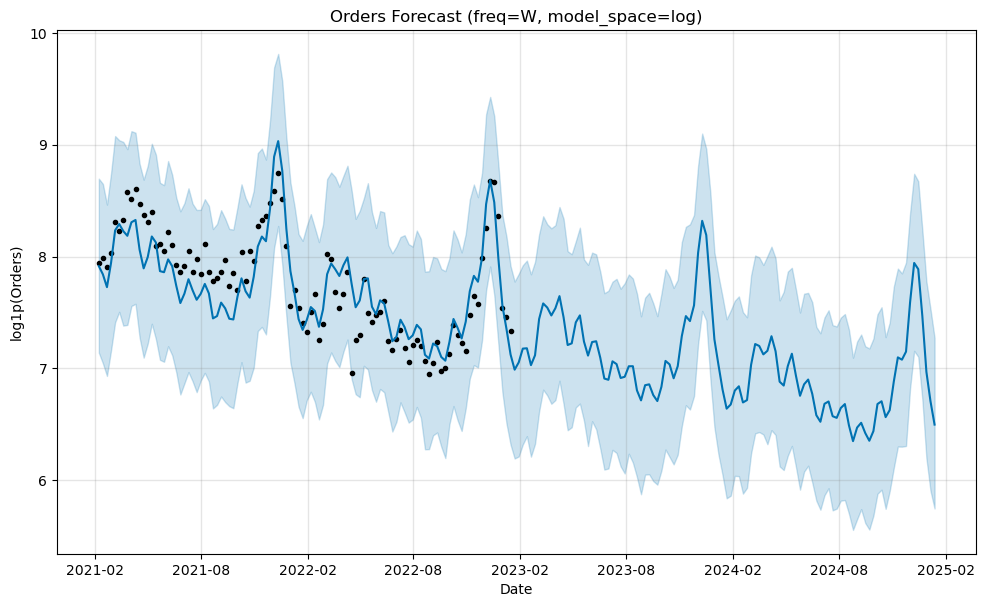

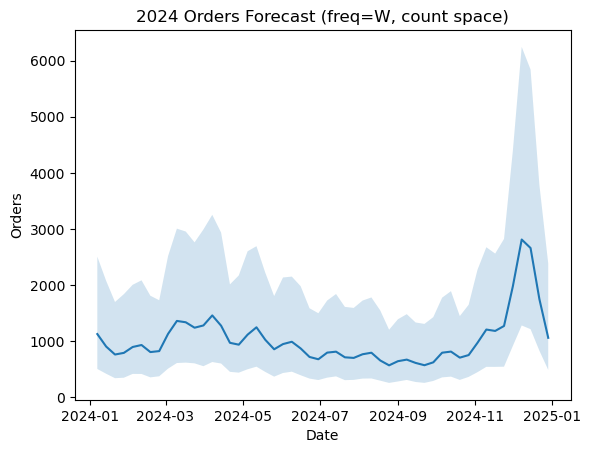

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

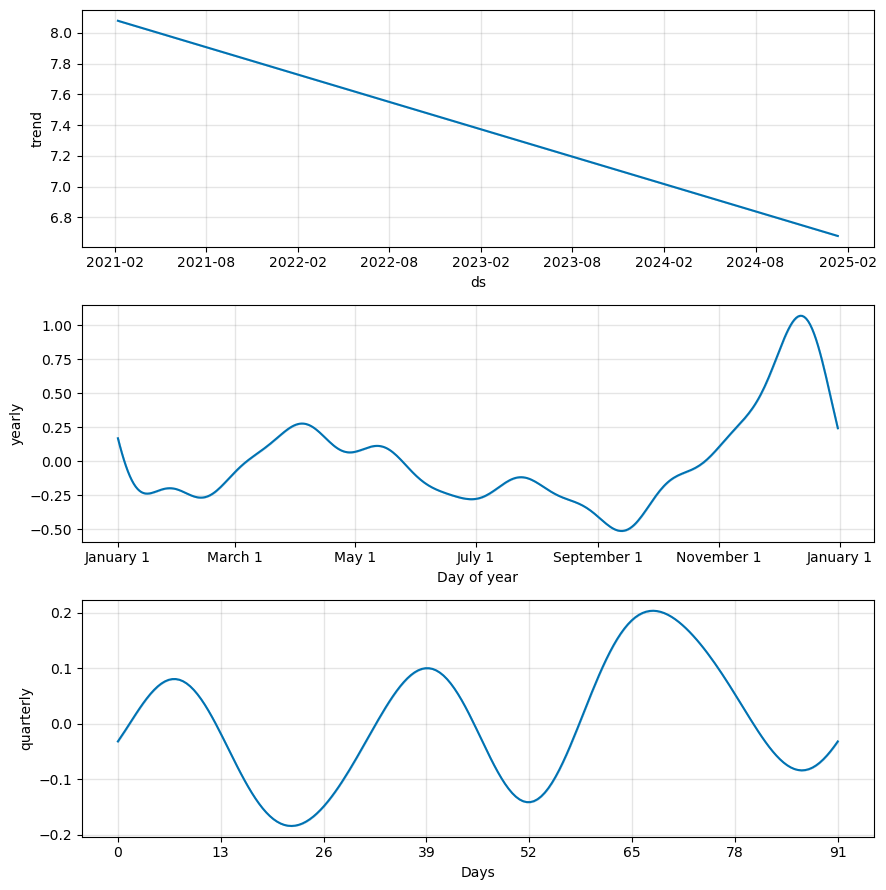

/var/folders/3g/fzqltvr90_11xv3v1sxb4f2m0000gn/T/ipykernel_73909/654023277.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sim = sim_df.resample("M").sum()
/var/folders/3g/fzqltvr90_11xv3v1sxb4f2m0000gn/T/ipykernel_73909/2407217243.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M", on=timestamp_col)


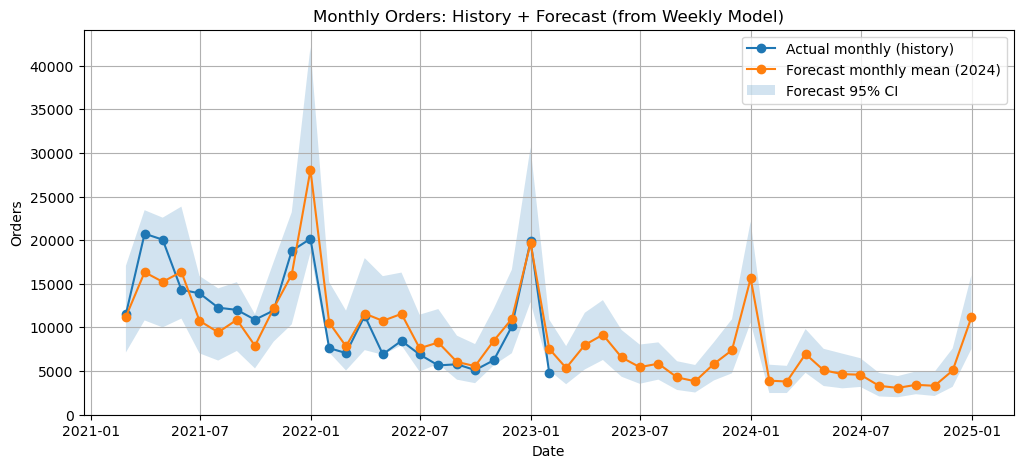

        ds    pred_mean   ci95_lower   ci95_upper
2021-02-28 11230.039319  7120.625411 17065.620799
2021-03-31 16325.392538 10798.109956 23436.643068
2021-04-30 15224.780805  9997.889909 22580.098715
2021-05-31 16366.373725 11009.228338 23847.009809
2021-06-30 10752.738071  7023.520467 15893.414708
2021-07-31  9436.588543  6195.568758 14471.155172
2021-08-31 10874.859391  7294.690729 15182.293565
2021-09-30  7890.252729  5295.039714 11508.049982
2021-10-31 12186.993746  8364.792211 17494.458001
2021-11-30 16058.448694 10342.812583 23206.001167
2021-12-31 28053.075443 18547.660693 42125.454983
2022-01-31 10549.518943  7135.163599 15204.908795
2022-02-28  7827.917707  5055.516718 11919.293483
2022-03-31 11578.722633  7391.731831 17944.943696
2022-04-30 10748.913300  6852.072114 15873.689875
2022-05-31 11549.692796  7933.840039 16283.597343
2022-06-30  7607.519401  4928.217916 11450.227086
2022-07-31  8265.575550  5814.812200 12100.015737
2022-08-31  6034.143986  4003.495045  9044.942787


In [46]:
out_w = prophet_forecast_with_scale(weekly_series, freq="W",
    changepoint_prior_scale=0.001, seasonality_prior_scale=0.1, seasonality_mode="additive"
    )
m = out_w["model"]

monthly_preds = weekly_to_monthly_with_ci(m, periods=104, start_date="2021-01-01",
    end_date="2024-12-31", is_log_model=True, plot=False)
plot_monthly_history_plus_forecast(df_orders, monthly_preds)
print(monthly_preds.to_string(index=False))

In [47]:
actual_monthly = (
    df_orders
    .resample("M", on="event_timestamp")
    .size()
    .reset_index(name="actual")
    .rename(columns={"event_timestamp": "ds"})
)

actual_monthly["ds"] = pd.to_datetime(actual_monthly["ds"]).dt.tz_localize(None)
eval_df = monthly_preds.merge(actual_monthly, on="ds", how="inner")

mse = np.mean((eval_df["actual"] - eval_df["pred_mean"])**2)
rmse = np.sqrt(mse)

print("Monthly MSE:", mse)
print("Monthly RMSE:", rmse)

Monthly MSE: 8328723.578751749
Monthly RMSE: 2885.952802585612


/var/folders/3g/fzqltvr90_11xv3v1sxb4f2m0000gn/T/ipykernel_73909/2698137010.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M", on="event_timestamp")


In [49]:
actual_monthly

,ds,actual
0,2021-02-28,11521
1,2021-03-31,20746
2,2021-04-30,20055
3,2021-05-31,14305
4,2021-06-30,13911
5,2021-07-31,12259
6,2021-08-31,12003
7,2021-09-30,10882
8,2021-10-31,11932
9,2021-11-30,18780


In [48]:
eval_df.head(100)

,ds,pred_mean,ci95_lower,ci95_upper,actual
0,2021-02-28,11230.039319,7120.625411,17065.620799,11521
1,2021-03-31,16325.392538,10798.109956,23436.643068,20746
2,2021-04-30,15224.780805,9997.889909,22580.098715,20055
3,2021-05-31,16366.373725,11009.228338,23847.009809,14305
4,2021-06-30,10752.738071,7023.520467,15893.414708,13911
5,2021-07-31,9436.588543,6195.568758,14471.155172,12259
6,2021-08-31,10874.859391,7294.690729,15182.293565,12003
7,2021-09-30,7890.252729,5295.039714,11508.049982,10882
8,2021-10-31,12186.993746,8364.792211,17494.458001,11932
9,2021-11-30,16058.448694,10342.812583,23206.001167,18780


In [50]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

mae = mean_absolute_error(eval_df["actual"], eval_df["pred_mean"])
mape = mean_absolute_percentage_error(eval_df["actual"], eval_df["pred_mean"])
r2 = r2_score(eval_df["actual"], eval_df["pred_mean"])

print(f"MAE: {mae}")
print(f"MAPE: {mape:.2%}")
print(f"R2 Score: {r2}")

MAE: 2236.2511686163184
MAPE: 21.64%
R2 Score: 0.6884521012878417
